In [5]:
import matplotlib
matplotlib.use('nbagg')
# %matplotlib notebook
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# this is stolen from some python project
from numpy import complex, sum, abs, pi, arange, array, size, shape, real, sqrt
from numpy import matrix, sqrt, sum, zeros, concatenate, sinc
from numpy.random import randn, seed, random
def awgn(input_signal, snr_dB, rate=1.0):
    """
    Addditive White Gaussian Noise (AWGN) Channel.
    Parameters
    ----------
    input_signal : 1D ndarray of floats
        Input signal to the channel.
    snr_dB : float
        Output SNR required in dB.
    rate : float
        Rate of the a FEC code used if any, otherwise 1.
    Returns
    -------
    output_signal : 1D ndarray of floats
        Output signal from the channel with the specified SNR.
    """

    avg_energy = sum(abs(input_signal) * abs(input_signal))/len(input_signal)
    snr_linear = 10**(snr_dB/10.0)
    noise_variance = avg_energy/(2*rate*snr_linear)

    noise = (sqrt(noise_variance) * randn(len(input_signal))) + (sqrt(noise_variance) * randn(len(input_signal))*1j)

    output_signal = input_signal + noise

    return output_signal

In [7]:
iq = scipy.fromfile(open('/home/gaspar/git/fm_fhss/phantom2/uksetaga_f2405350000.00_fs2181818.18_rx6_30_0_band2000000.00.iq'), dtype=scipy.complex64)
iq = iq[500000:507000]
iq = awgn(iq, 10)

<IPython.core.display.Javascript object>


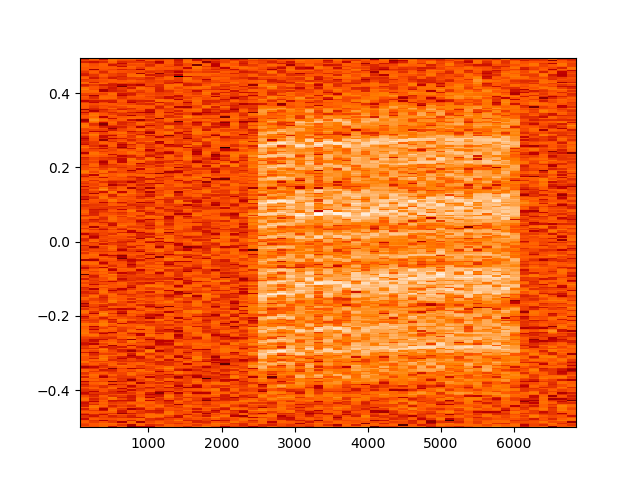

In [8]:
Pxx, freqs, bins, im = plt.specgram(iq, cmap=plt.cm.gist_heat, Fs= 1.0)
plt.show()

<IPython.core.display.Javascript object>


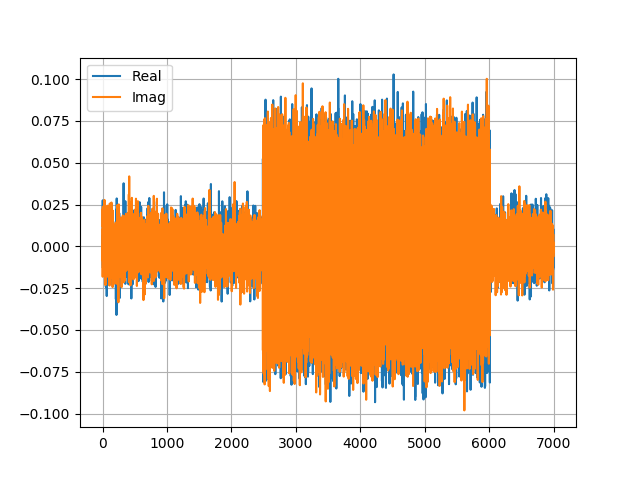

In [9]:
iqs = iq
plt.plot(iqs.real, label='Real')
plt.plot(iqs.imag, label='Imag')
plt.legend()
plt.grid()
plt.show()